In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics

In [2]:
train_df = pd.read_csv('D:\\Random\\Для PC\\Data and ML\\datasets\\HOUSE PRICE PREDICTION - SEATTLE\\train.csv')
test_df = pd.read_csv('D:\\Random\\Для PC\\Data and ML\\datasets\\HOUSE PRICE PREDICTION - SEATTLE\\test.csv')

In [3]:
train_df.head()

,beds,baths,size,size_units,lot_size,lot_size_units,zip_code,price
0,3,2.5,2590.0,sqft,6000.00,sqft,98144,795000.0
1,4,2.0,2240.0,sqft,0.31,acre,98106,915000.0
2,4,3.0,2040.0,sqft,3783.00,sqft,98107,950000.0
3,4,3.0,3800.0,sqft,5175.00,sqft,98199,1950000.0
4,2,2.0,1042.0,sqft,NaN,NaN,98102,950000.0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   beds            2016 non-null   int64  
 1   baths           2016 non-null   float64
 2   size            2016 non-null   float64
 3   size_units      2016 non-null   object 
 4   lot_size        1669 non-null   float64
 5   lot_size_units  1669 non-null   object 
 6   zip_code        2016 non-null   int64  
 7   price           2016 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 126.1+ KB


In [5]:
print(train_df['size_units'].unique())
print(test_df['size_units'].unique())

['sqft']
['sqft']


In [6]:
#удалим столбец 'size_units'
train_df = train_df.drop(columns = 'size_units')
test_df = test_df.drop(columns = 'size_units')

In [7]:
def convert_to_sqrf(df):
    if df['lot_size_units'] == 'acre':
        return df['lot_size'] * 43560
    
    else:
        return df['lot_size']

In [8]:
train_df['lot_size'] = train_df.apply(convert_to_sqrf, axis = 'columns')
test_df['lot_size'] = test_df.apply(convert_to_sqrf, axis = 'columns')

In [9]:
train_df = train_df.drop(columns = 'lot_size_units')
test_df = test_df.drop(columns = 'lot_size_units')

In [10]:
pd.options.display.float_format = '{:.2f}'.format
train_df.head()

,beds,baths,size,lot_size,zip_code,price
0,3,2.50,2590.00,6000.00,98144,795000.00
1,4,2.00,2240.00,13503.60,98106,915000.00
2,4,3.00,2040.00,3783.00,98107,950000.00
3,4,3.00,3800.00,5175.00,98199,1950000.00
4,2,2.00,1042.00,NaN,98102,950000.00


In [11]:
train_df = train_df.dropna()
test_df = test_df.dropna()

<Axes: >

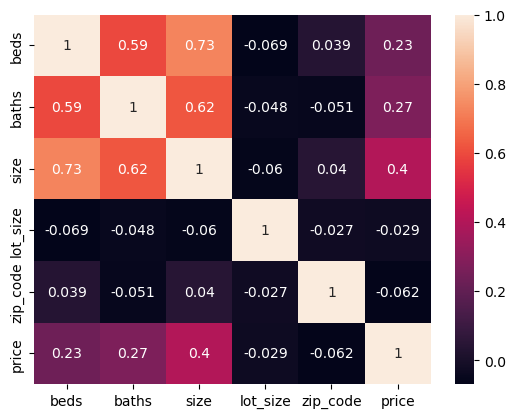

In [12]:
corr_train = train_df.corr()
sns.heatmap(corr_train, annot = True)

In [13]:
price = train_df['price']

In [14]:
price

0       795000.00
1       915000.00
2       950000.00
3      1950000.00
5       740000.00
          ...    
2009    675000.00
2010    699950.00
2011    910000.00
2013   1150000.00
2015    659000.00
Name: price, Length: 1669, dtype: float64

In [15]:
ves_x = train_df.drop(columns = 'price', axis = 1)

In [16]:
ves_x

,beds,baths,size,lot_size,zip_code
0,3,2.50,2590.00,6000.00,98144
1,4,2.00,2240.00,13503.60,98106
2,4,3.00,2040.00,3783.00,98107
3,4,3.00,3800.00,5175.00,98199
5,2,2.00,1190.00,43560.00,98107
...,...,...,...,...,...
2009,3,3.50,1680.00,1486.00,98126
2010,2,2.00,1400.00,14810.40,98199
2011,3,2.00,1370.00,21780.00,98112
2013,4,2.00,2140.00,6250.00,98199


In [17]:
X_train = train_df.drop(columns = 'price', axis = 1)
y_train = train_df['price']

In [18]:
X_test = test_df.drop(columns = 'price')
y_test = test_df['price']

In [19]:
regressors = {'LinReg': LinearRegression(), 
          'DecTree': DecisionTreeRegressor(), 
          'RandomForest': RandomForestRegressor()}

In [20]:
for name, model in regressors.items():
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    
    MSE = metrics.mean_squared_error(y_test, y_predict, squared=False)
    R2 = metrics.r2_score(y_test, y_predict)
    
    print(f'{name} has MSE = {MSE:.2f} and R2 = {R2:.2f}')

LinReg has MSE = 441110.91 and R2 = 0.49
DecTree has MSE = 1296182.21 and R2 = -3.40
RandomForest has MSE = 696715.65 and R2 = -0.27
